In [1]:
%matplotlib notebook

import json
import numpy as np
import numpy.random as npr
import scipy.stats as scs
import matplotlib.pyplot as plt
import matplotlib.ticker as mpt

from ast import literal_eval

In [2]:
BURN_IN = 20

base_parameters = {
    'k_a': 0.002,
    'k_d': 0.1,
    'mu': 3.0,
    'kappa': 1.0,
    'gamma': 0.04,
    'diffusion': 0.6,
    'time_step': 0.1,
    'cell_radius': 6.0,
    'nucleus_radius': 2.5,
}

def log_value(p, name=None):
    return (np.log10(base_parameters[name]) if name else 0) + p * np.log10(2)

def exp_value(p, name=None):
    return (p - (np.log10(base_parameters[name]) if name else 0))/np.log10(2)


def get_data(filename):
    with open(filename, 'r') as f:
        data = {model: {literal_eval(k): v for k, v in lklh.items()}
                for model, lklh in json.load(f).items()}
    return data

<IPython.core.display.Javascript object>


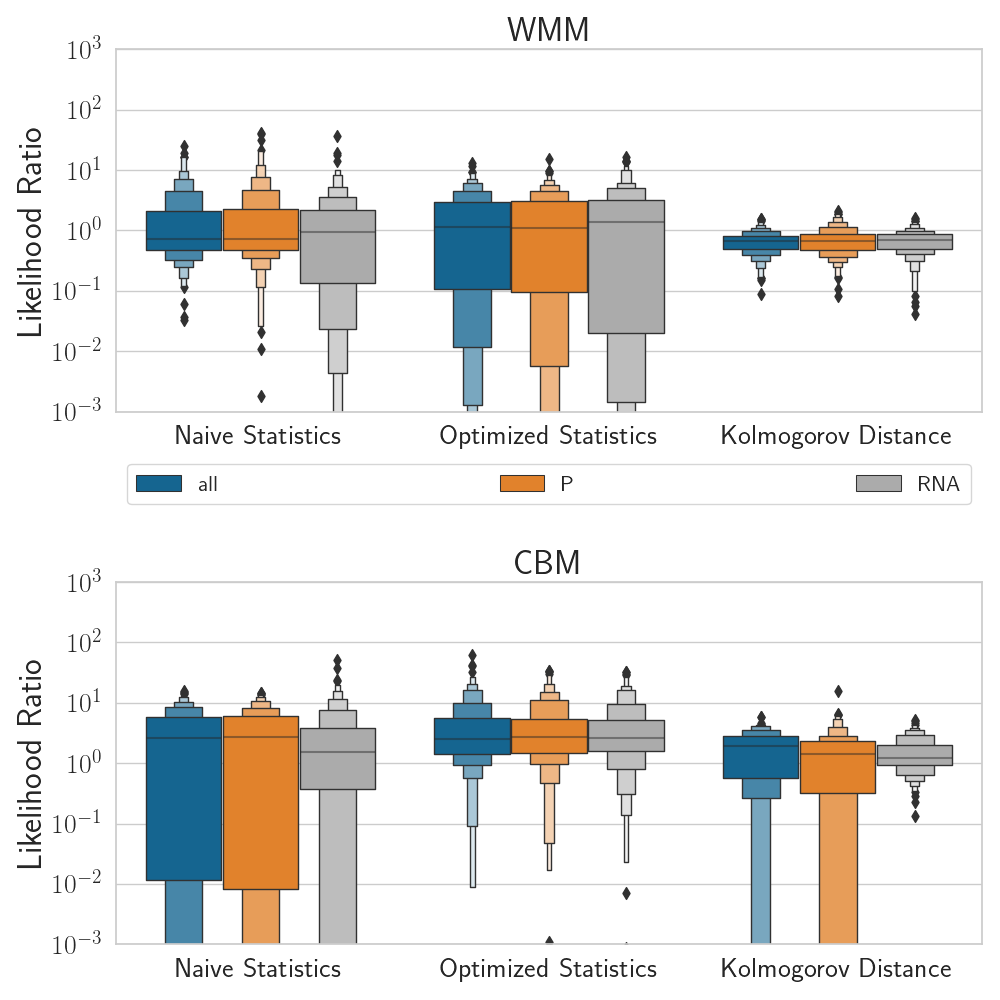

<IPython.core.display.Javascript object>


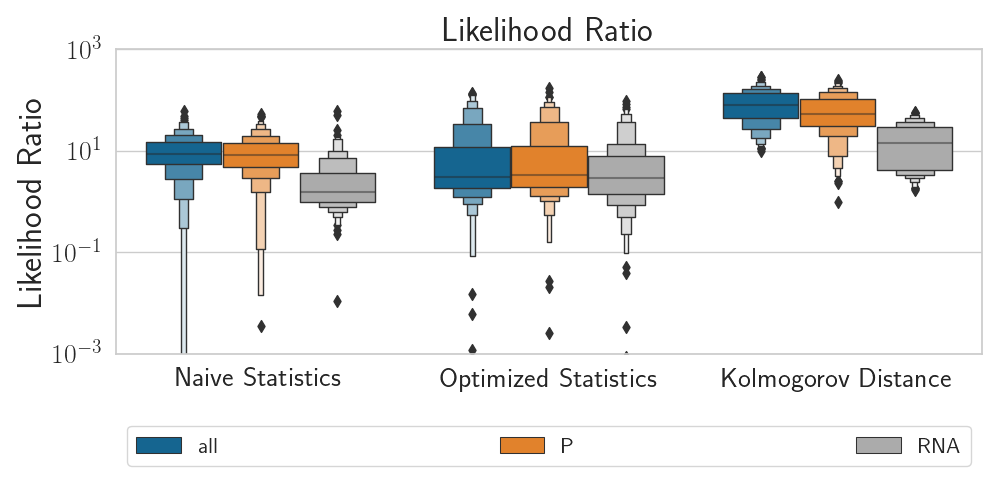

In [3]:
params = {
    'legend.fontsize': 16,
    'legend.title_fontsize': 18,
    'figure.figsize': (10, 16),
    'figure.titlesize': 28,
    'axes.labelsize': 24,
    'axes.titlesize':24,
    'xtick.labelsize':20,
    'ytick.labelsize':20,
    'text.usetex':True,
    'figure.autolayout':False,
}

import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid")
plt.style.use('tableau-colorblind10')

plt.rcParams.update(params)

prior = 1/50

solvers_groups = [['WMM', 'CBM'], ['smoldyn']]

metrics = {
    'ss': 'Naive Statistics',
    'ssAdv': 'Optimized Statistics',
    'kg': 'Kolmogorov Distance',
}

for solvers in solvers_groups:
    fig, axes = plt.subplots(len(solvers), 1, sharex=False, sharey=True, figsize=(10, 5*len(solvers)))

    if len(solvers) == 1:
        axes = [axes]

    for i, (ax, solver) in enumerate(zip(axes, solvers)):
        traj = 'h'
        tsamp = 'h'

        labels = [
            (species, dist)
            for species in ['all', 'P', 'RNA']
            for dist in ['ss', 'ssAdv', 'kg']
        ]

        lklh = [
                (v/prior, species, metrics[dist])
            for species, dist in labels
            for (_, _, k_d), v in get_data(
                    '../{dist}/lklh_{dist}_{species}_{traj}{tsamp}.json'.format(
                        dist=dist, species=species, traj=traj, tsamp=tsamp)
                )[solver].items() if k_d == 0
        ]

        df_lklh = pd.DataFrame(lklh, columns=['Likelihood Ratio', 'species', 'dist'])

        sns.boxenplot(ax=ax, data=df_lklh, y='Likelihood Ratio', hue='species', x='dist')

        ax.set_yscale('log')
        ax.legend(bbox_to_anchor=(0, -0.2, 1, 0), mode="expand", ncol=3)

        ax.set_ylim(1.e-3, 1.e3)
        if len(solvers) > 1:
            ax.set_title(solver)
        else:
            ax.set_title('Likelihood Ratio')
        if i != 0:
            ax.legend().set_visible(False)
        ax.set_xlabel(None)

    fig.tight_layout()

    plt.savefig(f"RNAvsP{'-'.join(solvers)}_lklh.pdf", dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


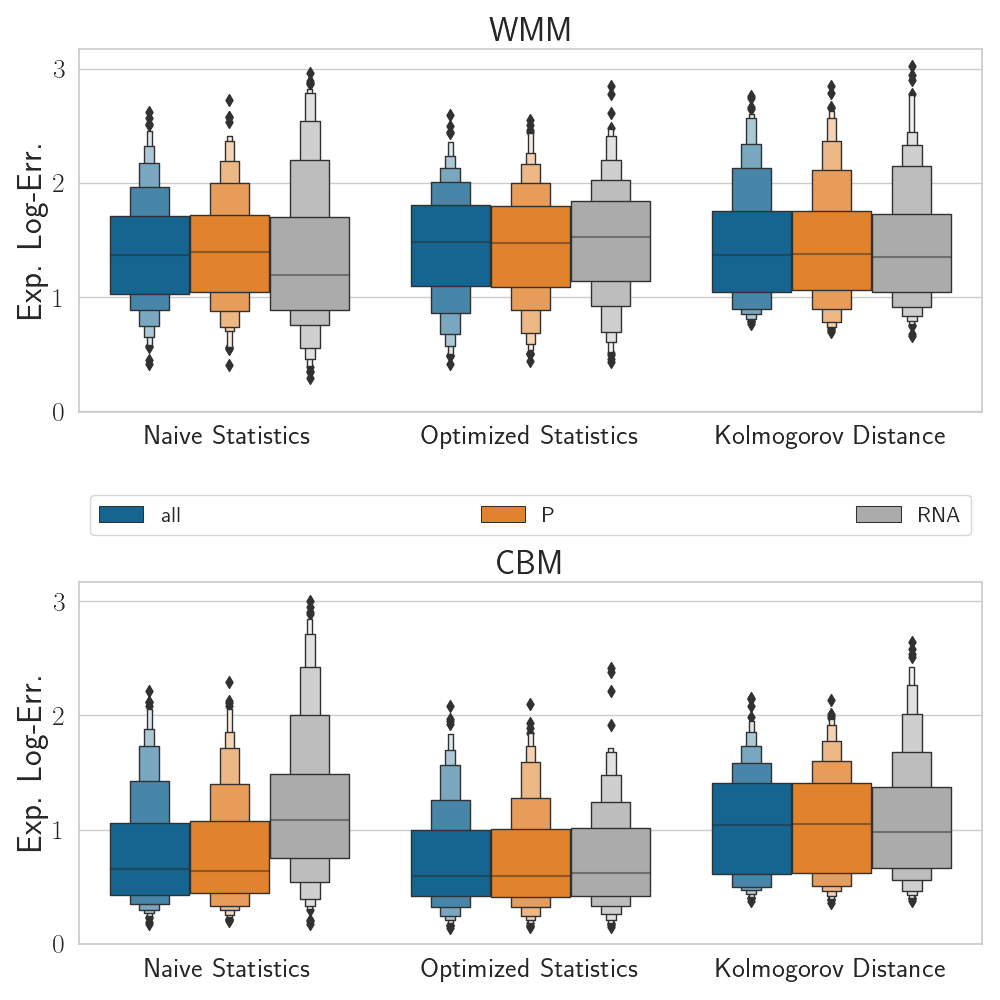

<IPython.core.display.Javascript object>


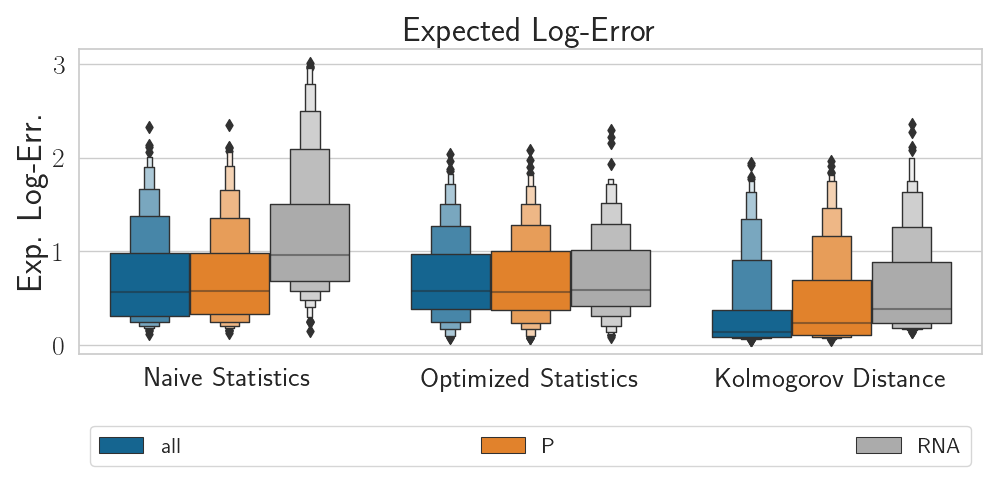

In [4]:
params = {
    'legend.fontsize': 16,
    'legend.title_fontsize': 18,
    'figure.figsize': (10, 16),
    'figure.titlesize': 28,
    'axes.labelsize': 24,
    'axes.titlesize':24,
    'xtick.labelsize':20,
    'ytick.labelsize':20,
    'text.usetex':True,
    'figure.autolayout':False,
}

import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid")
plt.style.use('tableau-colorblind10')

plt.rcParams.update(params)

solvers_groups = [['WMM', 'CBM'], ['smoldyn']]

metrics = {
    'ss': 'Naive Statistics',
    'ssAdv': 'Optimized Statistics',
    'kg': 'Kolmogorov Distance',
}

for solvers in solvers_groups:
    fig, axes = plt.subplots(len(solvers), 1, sharex=False, sharey=True, figsize=(10, 5*len(solvers)))

    if len(solvers) == 1:
        axes = [axes]

    for i, (ax, solver) in enumerate(zip(axes, solvers)):
        traj = 'h'
        tsamp = 'h'

        labels = [
            (species, dist)
            for species in ['all', 'P', 'RNA']
            for dist in ['ss', 'ssAdv', 'kg']
        ]

        expvalues = [
                (v, species, metrics[dist])
            for species, dist in labels
            for (_, _, k_d), v in get_data(
                    '../{dist}/logexpvalue_{dist}_{species}_{traj}{tsamp}.json'.format(
                        dist=dist, species=species, traj=traj, tsamp=tsamp)
                )[solver].items() if k_d == 0
        ]

        df_expvalues = pd.DataFrame(expvalues, columns=['expvalue', 'species', 'dist'])

        sns.boxenplot(ax=ax, data=df_expvalues, y='expvalue', hue='species', x='dist')

        #ax.set_yscale('log')
        #ax.set_ylim(0, 3)
        ax.set_ylabel('Exp. Log-Err.')
        ax.legend(bbox_to_anchor=(0, -0.2, 1, 0), mode="expand", ncol=3)

        if len(solvers) > 1:
            ax.set_title(solver)
        else:
            ax.set_title('Expected Log-Error')
        if i != 0:
            ax.legend().set_visible(False)
        ax.set_xlabel(None)

    fig.tight_layout()

    plt.savefig(f"RNAvsP{'-'.join(solvers)}_error.pdf", dpi=300, bbox_inches='tight')